In [ ]:
print('Final Project')

Final Project


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -n sage sage python=3.10

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/sage

  added / updated specs:
    - python=3.10
    - sage


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge 
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu 
  _r-mutex           conda-forge/noarch::_r-mutex-1.0.1-anacondar_1 
  _x86_64-microarch~ conda-forge/noarch::_x86_64-microarch-level-3-2_broadwell 
  alabaster          conda-forge/noarch::alabaster-0.7.16-pyhd8ed1ab_0 
  alsa-lib           conda-forge/linux-64::alsa-lib-1.2.14-hb9d3cd8_0 
  anyio              conda-forge/noarch::anyio-4.9.0-pyh29332c3_0 

In [ ]:
%pip install cython
%pip install --upgrade pyknotid

In [ ]:
%pip install --upgrade yfinance==0.2.54

In [ ]:
%pip install diskcache

In [ ]:
%pip install nest_asyncio

In [ ]:
"""
TOPOLOGICAL FINANCIAL CRISIS DETECTION PIPELINE
Version 3.2 - Robust Production Implementation

Key Enhancements:
1. Anti-blocking request patterns with rotating headers
2. Hybrid data fetching (direct API + yfinance fallback)
3. Rate limit management with adaptive throttling
4. Comprehensive data validation at all stages
5. Graceful degradation for failed components
6. Caching with size/compression controls
7. Phase-aware temporal processing
"""

# ======================
# ENVIRONMENT CONFIGURATION
# ======================
import pandas as pd
import numpy as np
import shutil
import logging
from datetime import timedelta
from tqdm import tqdm
import aiohttp
import asyncio
from tenacity import retry, stop_after_attempt, wait_random_exponential
from diskcache import Cache
import nest_asyncio
import random
import yfinance as yf

# ENHANCEMENT: Solve Jupyter/Colab async conflicts
nest_asyncio.apply()

# ======================
# GLOBAL CONFIGURATION
# ======================
# ENHANCEMENT: Optimized cache with compression and size limits
cache = Cache('financial_data',
             size_limit=int(3e9),          # 3GB maximum cache size
             compression=3,   # Balance speed vs compression
             disk_min_file_size=int(1e6))  # Only compress large files

# ENHANCEMENT: Reduced logging noise for production
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

# ======================
# DATA DEFINITIONS
# ======================
# ENHANCEMENT: Simplified event structure for reliability testing
EVENTS = {
    'black_monday': {
        'era_start': '1987-08-15',
        'era_end': '1988-02-15',
        'crisis_start': '1987-10-12',
        'crisis_end': '1987-10-26',
        'tickers': ['IBM', 'KO']
    },
    'black_monday:initial_collapse':{
        'sub_phase_start': '1987-10-12',
        'sub_phase_end': '1987-10-16',
        'tickers': ['IBM', 'KO']
    },
    'black_monday:peak_volatility':{
        'sub_phase_start': '1987-10-19',
        'sub_phase_end': '1987-10-23',
        'tickers': ['IBM', 'KO']
    },
    'black_monday:recovery_attempt':{
        'sub_phase_start': '1987-10-24',
        'sub_phase_end': '1987-10-26',
        'tickers': ['IBM', 'KO']
    },

    '2008_crisis': {
        'era_start': '2007-12-01',
        'era_end': '2009-06-01',
        'crisis_start': '2008-09-15',
        'crisis_end': '2008-09-29',
        'tickers': ['BAC', 'C']
    },
    '2008_crisis:lehman_collapse':{ #Trigger
        'sub_phase_start': '2008-09-15',
        'sub_phase_end': '2008-09-19',
        'tickers': ['BAC', 'C']
    },
    '2008_crisis:credit_freeze':{ #peak in market volatility
        'sub_phase_start': '2008-09-22',
        'sub_phase_end': '2008-09-26',
        'tickers': ['BAC', 'C']
    },
    '2008_crisis:bailout_announcement':{
        'sub_phase_start': '2008-09-29',
        'sub_phase_end': '2008-10-03',
        'tickers': ['BAC', 'C']
    },

    'covid': {
        'era_start': '2019-12-01',
        'era_end': '2020-06-01',
        'crisis_start': '2020-03-01',
        'crisis_end': '2020-03-15',
        'tickers': ['AMZN', 'PFE']
    },
    'covid:global_spread':{ #Trigger
        'sub_phase_start': '2020-03-02',
        'sub_phase_end': '2020-03-06',
        'tickers': ['AMZN', 'PFE'],
    },
    'covid:circuit_breakers':{
        #peak in market volatility-as circuit breakers are responses to peaks in market volatility
        'sub_phase_start': '2020-03-09',
        'sub_phase_end': '2020-03-13',
        'tickers': ['AMZN', 'PFE'],
    },
    'covid:initial_stabilization_relief':{
        #Initial CB policy responses aiming to stabilize markets and provide relief to prevent a deeper downturn.
        'sub_phase_start': '2020-03-16',
        'sub_phase_end': '2020-04-03', # Shortened to be more consistent
        'tickers': ['AMZN', 'PFE'],
    },

    'current': {
        'era_start': '2025-01-20',
        'era_end': '2025-04-20',
        'tariffs_start': '2025-02-01',
        'tariffis_pause': '2025-04-09',
        'tickers': ['NVDA', 'WMT']
    },
    'current:tariff_announcement':{ #Trigger
        'sub_phase_start': '2025-02-01',
        'sub_phase_end': '2025-02-14',
        'tickers': ['NVDA', 'WMT']
    },
    'current:market_reaction':{
        'sub_phase_start': '2025-02-15',
        'sub_phase_end': '2025-03-15',
        'tickers': ['NVDA', 'WMT']
    },
    'current:stabilization_after_reaction':{
        'sub_phase_start': '2025-03-16',
        'sub_phase_end': '2025-04-01',
        'tickers': ['NVDA', 'WMT']
    }
}

test_EVENTS = {
    'covid_short': {
        # CHANGED: Tightened window around COVID crash
        'era_start': '2020-01-01',
        'era_end': '2020-04-30',
        'crisis_start': '2020-02-20',  # Market peak before crash
        'crisis_end': '2020-03-23',    # Initial recovery
        # CHANGED: Removed problematic tickers (ZM, NFLX)
        'tickers': ['AMZN', 'TSLA']     # High-volume COVID-era movers
    }
}

# ENHANCEMENT: Pruned to most reliable tickers
COMMON_TICKERS = [
    'SPY',  # Reliable SPDR S&P 500 ETF
    'AGG',  # index measures the performance of the total U.S. investment-grade bond market.
    'AAPL', # Consistent historical data
    'JPM',  # Major bank with full history
    'XOM'   # Oil giant with stable reporting
]

# ======================
# ANTI-BLOCKING MECHANISMS
# ======================
# ENHANCEMENT: Rotating user agents to prevent fingerprinting
USER_AGENTS = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 14_3_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Safari/605.1.15',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'
]

# ENHANCEMENT: Security headers mimicking browser behavior
HEADERS = {
    'Accept': 'application/json',       # Force JSON responses
    'Accept-Encoding': 'gzip, deflate, br',  # Enable compression
    'DNT': '1',                         # Do Not Track request
    'Connection': 'keep-alive',         # Reuse connections
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site'
}

# ======================
# RATE LIMIT CONTROLS
# ======================
REQUEST_CONFIG = {
    'max_concurrent': 2,       # Simultaneous requests allowed
    'delay_range': (3, 5),     # ENHANCEMENT: Increased from 1.5-3s
    'batch_size': 2,           # Tickers per batch
    'batch_delay': 15,         # ENHANCEMENT: Increased from 10s
    'max_retries': 4,          # CHANGED: From 3 to 4 attempts
    'retry_backoff': 2         # Multiplier for retry delays
}

# ======================
# CORE FUNCTIONS
# ======================
"""
  ENHANCEMENT: Dynamic phase windows with buffer periods
    Constructs pre-crisis, crisis, and non-crisis windows with:
    - 10-day pre-crisis observation buffer
    - 3-day post-crisis stabilization period
    - Random non-crisis sampling avoiding event periods
"""
def generate_adaptive_windows(event, event_name=""):
    """Generate phase windows with subphase support"""
    periods = {'pre_crisis': [], 'crisis': [], 'non_crisis': []}
    try:
        is_sub_event = 'sub_phase_start' in event

        if is_sub_event:
            # Sub-event processing with 7-day buffers
            start = pd.to_datetime(event['sub_phase_start'])
            end = pd.to_datetime(event['sub_phase_end'])
            periods['crisis'] = [{
                'start': start,
                'end': end,
                'subphase': event_name.split(':')[-1]
            }]
            periods['pre_crisis'] = [{
                'start': start - pd.Timedelta(days=7),
                'end': start - pd.Timedelta(days=1)
            }]
            periods['non_crisis'] = [{
                'start': end + pd.Timedelta(days=1),
                'end': end + pd.Timedelta(days=14)
            }]
        else:
            # Main event processing with crisis buffers
            crisis_start = pd.to_datetime(event['crisis_start'])
            crisis_end = pd.to_datetime(event['crisis_end'])
            periods['pre_crisis'] = [{
                'start': crisis_start - pd.Timedelta(days=10),
                'end': crisis_start - pd.Timedelta(days=1)
            }]
            periods['crisis'] = [{
                'start': crisis_start - pd.Timedelta(days=2),
                'end': crisis_end + pd.Timedelta(days=3)
            }]
            periods['non_crisis'] = [
                {'start': pd.to_datetime(event['era_start']), 'end': pd.to_datetime(event['era_start']) + pd.Timedelta(days=7)},
                {'start': crisis_end + pd.Timedelta(days=7), 'end': crisis_end + pd.Timedelta(days=14)}
            ]
        return periods
    except KeyError as e:
        logger.error(f"Missing key in {event_name}: {str(e)}")
        return periods

# ======================
# ENHANCED TICKER VALIDATION (UPDATED)
# ======================
"""
    ENHANCEMENT: Comprehensive ticker validation
    Verifies:
    1. Basic price data availability
    2. Volume information existence
    3. Recent trading activity
    4. No suspended/defunct status
    """
def validate_ticker(ticker, event_start, event_end):
    """Check if ticker has data within EVENT date range"""
    try:
        t = yf.Ticker(ticker)
        hist = t.history(start=event_start, end=event_end, timeout=10)
        return not hist.empty and 'Close' in hist.columns
    except Exception as e:
        logger.warning(f"Validation error: {str(e)[:50]}...")
        return False

@retry(stop=stop_after_attempt(REQUEST_CONFIG['max_retries']),
       wait=wait_random_exponential(
           multiplier=REQUEST_CONFIG['retry_backoff'],
           max=60),
       retry_error_callback=lambda _: pd.Series())


async def fetch_ticker(session, ticker, start, end):
    """
    ENHANCEMENT: Robust Yahoo Finance API handler with:
    - Rotating user agents
    - Randomized delays
    - Response validation
    - Error containment
    - Static crumb fallback
    """
    HEADERS['User-Agent'] = random.choice(USER_AGENTS)

    params = {
        'period1': int(pd.Timestamp(start).timestamp()),
        'period2': int(pd.Timestamp(end).timestamp()),
        'interval': '1d',        # ENHANCEMENT: Default to daily
        'includePrePost': 'false',
        'events': 'div,splits',
        'crumb': 'v8w3z5ldd74'   # CHANGED: Static crumb fallback
    }

    try:
        # ENHANCEMENT: Randomized delay with jitter
        delay = random.uniform(*REQUEST_CONFIG['delay_range'])
        await asyncio.sleep(delay)

        async with session.get(
            f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}",
            params=params,
            headers=HEADERS,
            timeout=30
        ) as response:
            # ENHANCEMENT: Content-type validation
            content_type = response.headers.get('Content-Type', '')
            if 'application/json' not in content_type:
                raise ValueError(f"Unexpected content type: {content_type}")

            # ENHANCEMENT: HTTP status handling
            if response.status == 429:
                logger.warning("Rate limit detected")
                await asyncio.sleep(60)  # Full minute cooldown
                raise Exception("Rate limited")

            data = await response.json()

            # ENHANCEMENT: Deep response validation
            if not data.get('chart', {}).get('result'):
                logger.warning(f"Empty chart data for {ticker}")
                return pd.Series()

            result = data['chart']['result'][0]
            timestamps = result.get('timestamp', [])
            quotes = result.get('indicators', {}).get('quote', [{}])[0]
            prices = quotes.get('close', [])

            # ENHANCEMENT: Length validation
            if len(timestamps) != len(prices):
                logger.warning(f"Data mismatch for {ticker}")
                return pd.Series()

            return pd.Series(
                prices,
                index=pd.to_datetime(timestamps, unit='s', utc=True).tz_convert(None),
                name=ticker
            )

    except Exception as e:
        logger.warning(f"Request failed for {ticker}: {str(e)[:50]}...")
        return pd.Series()

async def fetch_all_tickers(tickers, start, end):
    """
    ENHANCEMENT: Batch processor with:
    - Concurrency limits
    - Inter-batch delays
    - Connection pooling
    - Progress tracking
    """
    async with aiohttp.ClientSession(headers=HEADERS) as session:
        semaphore = asyncio.Semaphore(REQUEST_CONFIG['max_concurrent'])
        results = []

        # ENHANCEMENT: Batch processing with cooling periods
        batches = [tickers[i:i+REQUEST_CONFIG['batch_size']]
                  for i in range(0, len(tickers), REQUEST_CONFIG['batch_size'])]

        for batch in batches:
            tasks = []
            for t in batch:
                async with semaphore:
                    tasks.append(fetch_ticker(session, t, start, end))

            batch_results = await asyncio.gather(*tasks)
            results += batch_results

            # ENHANCEMENT: Inter-batch cooling
            await asyncio.sleep(REQUEST_CONFIG['batch_delay'])

        return results

# ======================
# DATA PROCESSING PIPELINE
# ======================
@cache.memoize(expire=86400)
def fetch_market_data(tickers, start, end):
    """Enhanced with date-range validation and post-fetch cleanup"""
    valid_tickers = [t for t in tickers if validate_ticker(t, start, end)]
    if not valid_tickers:
        raise ValueError("No valid tickers available")

    try:
        loop = asyncio.get_event_loop()
        async_data = loop.run_until_complete(fetch_all_tickers(valid_tickers, start, end))
        combined = pd.concat([s for s in async_data if not s.empty], axis=1)
    except Exception:
        data = yf.download(
            valid_tickers,
            start=pd.to_datetime(start)-timedelta(days=45),
            end=pd.to_datetime(end)+timedelta(days=45),
            group_by='ticker'
        )
        combined = data['Close'] if len(valid_tickers) > 1 else data[['Close']]

    # Post-fetch cleaning for event window
    mask = (combined.index >= pd.to_datetime(start)) & (combined.index <= pd.to_datetime(end))
    combined = combined.loc[mask].ffill().resample('1D').last()
    return combined.dropna(axis=1, how='all')


def calculate_normalized_returns(df, lookback=30):
    """
    ENHANCEMENT: Robust normalization with:
    - Dynamic min_periods for short windows
    - Epsilon protection against zero-division
    - Improved NaN handling
    """
    """Dynamic normalization with phase-length awareness"""
    lrets = np.log(df).diff().dropna()
    if lrets.empty:
        return pd.DataFrame(0, index=df.index, columns=df.columns)

    # Dynamic lookback adjustment
    data_length = len(lrets)
    dynamic_lookback = min(lookback, data_length)

    if dynamic_lookback < 5:  # Use whole-window stats for short phases
        mean = lrets.mean()
        std = lrets.std().replace(0, 1e-6)
    else:
        min_periods = max(1, int(dynamic_lookback * 0.2))
        mean = lrets.rolling(dynamic_lookback, min_periods=min_periods).mean()
        std = lrets.rolling(dynamic_lookback, min_periods=min_periods).std()

    std = std.replace(0, 1e-6) + 1e-6  # Prevent division by zero
    normalized = (lrets - mean) / std

    return normalized.replace([np.inf, -np.inf], np.nan).ffill(limit=3).bfill(limit=3).fillna(0)

# ======================
# UPDATED PROCESS_WINDOWS
# ======================
"""
    INTIAL ENHANCEMENTS: Phase-aware processor with:
    - Crisis phase detection
    - Adaptive resampling
    - Numeric validation
    - Ranking generation
    """
def process_windows(combined, periods):
    """Uniform daily resampling and enhanced validation"""
    event_data = {'pre_crisis': [], 'crisis': [], 'non_crisis': []}

    for phase in ['pre_crisis', 'crisis', 'non_crisis']:
        for period in periods.get(phase, []):
            try:
                window_data = combined.loc[period['start']:period['end']].ffill()
                if window_data.empty:
                    continue

                # Always use daily resampling
                resampled = window_data.resample('1D').last()

                entry = {
                    'prices': resampled,
                    'returns': np.log(resampled).diff().dropna(),
                    'normalized': calculate_normalized_returns(resampled),
                    'start': period['start'],
                    'end': period['end']
                }

                if 'subphase' in period:
                    entry['subphase'] = period['subphase']
                    entry['ranking'] = entry['normalized'].rank(axis=1, method='dense', ascending=False)

                event_data[phase].append(entry)
            except Exception as e:
                logger.warning(f"Processing failed: {str(e)[:50]}...")

    return event_data

def fetch_optimized_data():
    """
    ENHANCEMENT: Main pipeline with:
    - Progress tracking
    - Validation gates
    - Error containment
    - Graceful degradation
    """
    data = {}
    for event_name, event in EVENTS.items():
        try:
            is_sub_event = 'sub_phase_start' in event
            event_start = event['sub_phase_start'] if is_sub_event else event['era_start']
            event_end = event['sub_phase_end'] if is_sub_event else event['era_end']

            all_tickers = list(set(COMMON_TICKERS + event['tickers']))
            valid_tickers = [t for t in all_tickers if validate_ticker(t, event_start, event_end)]  # Fixed call
            if not valid_tickers:
                raise ValueError(f"No valid tickers for {event_name}")

            with tqdm(total=1, desc=f"Processing {event_name}") as pbar:
                combined = fetch_market_data(tuple(valid_tickers),
                                           event['era_start'],
                                           event['era_end'])
                pbar.update(1)

            # ENHANCEMENT: Index validation
            if not isinstance(combined.index, pd.DatetimeIndex):
                raise ValueError("Invalid datetime index")

            periods = generate_adaptive_windows(event)
            event_data = process_windows(combined, periods)

            # ENHANCEMENT: Final validation
            if not any(event_data.values()):
                raise ValueError("No valid windows processed")

            data[event_name] = event_data

        except Exception as e:
              logger.error(f"Critical failure in {event_name}: {str(e)[:50]}...")
              # ENHANCEMENT: Graceful degradation
              data[event_name] = {
                    'error': str(e),
                    'traceback': None,  # Omitted for security
                    # Adding the pre_crisis, crisis, non_crisis keys here to maintain the structure
                    'pre_crisis': [],
                    'crisis': [],
                    'non_crisis': []
              }

    return data

# ======================
# VERIFICATION SYSTEM
# ======================
def verify_tickers(optimized_data):
    """Multi-stage validation reporter"""
    print("\n" + "="*40)
    print("CRISIS PHASE VALIDATION REPORT")
    print("="*40)

    for event_name, event_data in optimized_data.items():
        if 'error' in event_data:
            print(f"\n{event_name.upper()} ERROR: {event_data['error']}")
            continue

        print(f"\n{event_name.upper()} VALIDATION:")
        is_sub_event = ':' in event_name
        phase_filter = ['crisis'] if is_sub_event else ['pre_crisis', 'crisis', 'non_crisis']

        for phase in phase_filter:
            phase_data = event_data.get(phase, [])
            if not phase_data:
                continue

            print(f"  {phase.replace('_', ' ').title()} Phase:")
            for idx, period in enumerate(phase_data):
                label = (event_name.split(':')[-1].replace('_', ' ').title()
                        if is_sub_event else f"Window {idx+1}")

                if 'prices' not in period:
                    print(f"    {label}: Missing price data")
                    continue

                try:
                    valid_tickers = period['prices'].columns.tolist()
                    dates = f"{period['start'].date()} to {period['end'].date()}"
                    print(f"    {label} ({dates}): {valid_tickers}")
                except Exception as e:
                    print(f"    {label}: Data access error - {str(e)[:50]}")

# ======================
# EXECUTION CONTROLLER
# ======================
if __name__ == "__main__":
    try:
        shutil.rmtree('./financial_data', ignore_errors=True)
    except Exception as e:
        print(f"Cache cleanup warning: {str(e)}")

    print("\nStarting topological analysis...")
    optimized_data = {}

    for event_name, event in EVENTS.items():
        try:
            is_sub_event = 'sub_phase_start' in event
            event_start = event['sub_phase_start'] if is_sub_event else event['era_start']
            event_end = event['sub_phase_end'] if is_sub_event else event['era_end']

            tickers = list(set(COMMON_TICKERS + event['tickers']))
            valid_tickers = [t for t in tickers if validate_ticker(t, event_start, event_end)]  # Fixed call
            if not valid_tickers:
                raise ValueError(f"No valid tickers for {event_name}")

            date_range = (
                pd.to_datetime(event['sub_phase_start']) - pd.Timedelta(days=21),
                pd.to_datetime(event['sub_phase_end']) + pd.Timedelta(days=21)
            ) if is_sub_event else (
                event['era_start'], event['era_end']
            )

            with tqdm(total=1, desc=f"Processing {event_name}") as pbar:
                combined = fetch_market_data(tuple(valid_tickers), *date_range)
                pbar.update(1)

            periods = generate_adaptive_windows(event, event_name)
            event_data = process_windows(combined, periods)

            if is_sub_event:
                event_data = {'crisis': event_data.get('crisis', [])}

            optimized_data[event_name] = event_data
        except Exception as e:
            optimized_data[event_name] = {'error': str(e)}
            logger.error(f"Critical failure in {event_name}: {str(e)[:50]}...")

    print("\nRunning verification protocols...")
    verify_tickers(optimized_data)

    print("\n" + "="*40)
    print("PIPELINE STATUS REPORT")
    print("="*40)
    for event in EVENTS:
        status = "VALID" if 'error' not in optimized_data.get(event, {}) else "ERROR"
        print(f"{event.upper().ljust(35)} {status}")
    print("\nTopological processing complete")


Starting topological analysis...


ERROR:yfinance:$SPY: possibly delisted; no price data found  (1d 1987-08-15 -> 1988-02-15) (Yahoo error = "Data doesn't exist for startDate = 555998400, endDate = 571899600")
ERROR:yfinance:$AGG: possibly delisted; no price data found  (1d 1987-08-15 -> 1988-02-15) (Yahoo error = "Data doesn't exist for startDate = 555998400, endDate = 571899600")
Processing black_monday: 100%|██████████| 1/1 [01:00<00:00, 60.27s/it]
ERROR:yfinance:$SPY: possibly delisted; no price data found  (1d 1987-10-12 -> 1987-10-16) (Yahoo error = "Data doesn't exist for startDate = 561009600, endDate = 561355200")
ERROR:yfinance:$AGG: possibly delisted; no price data found  (1d 1987-10-12 -> 1987-10-16) (Yahoo error = "Data doesn't exist for startDate = 561009600, endDate = 561355200")
Processing black_monday:initial_collapse: 100%|██████████| 1/1 [00:59<00:00, 59.94s/it]
ERROR:yfinance:$SPY: possibly delisted; no price data found  (1d 1987-10-19 -> 1987-10-23) (Yahoo error = "Data doesn't exist for startDate =


Running verification protocols...

CRISIS PHASE VALIDATION REPORT

BLACK_MONDAY VALIDATION:
  Pre Crisis Phase:
    Window 1 (1987-10-02 to 1987-10-11): ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']
  Crisis Phase:
    Window 1 (1987-10-10 to 1987-10-29): ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']
  Non Crisis Phase:
    Window 1 (1987-08-15 to 1987-08-22): ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']
    Window 2 (1987-11-02 to 1987-11-09): ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']

BLACK_MONDAY:INITIAL_COLLAPSE VALIDATION:
  Crisis Phase:
    Initial Collapse (1987-10-12 to 1987-10-16): ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']

BLACK_MONDAY:PEAK_VOLATILITY VALIDATION:
  Crisis Phase:
    Peak Volatility (1987-10-19 to 1987-10-23): ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']

BLACK_MONDAY:RECOVERY_ATTEMPT ERROR: No valid tickers for black_monday:recovery_attempt

2008_CRISIS VALIDATION:
  Pre Crisis Phase:
    Window 1 (2008-09-05 to 2008-09-14): ['C', 'JPM', 'BAC', 'SPY', 'AAPL', 'XOM', 'AGG']
  Crisis Phase:
    Window 1 (200

In [ ]:
# ======================
# DATA STRUCTURE TRANSFORMATION
# ======================
def transform_format(optimized_data):
    """Convert optimized format to historical_data structure with safe phase access"""
    transformed = {}

    for event_name, event_data in optimized_data.items():
        if 'error' in event_data:
            transformed[event_name] = None
            continue

        transformed[event_name] = {
            'pre_crisis': [],
            'non_crisis': [],
            'crisis': []
        }

        # Safely handle missing phases
        for phase in ['pre_crisis', 'non_crisis', 'crisis']:
            # Use get() with default empty list to handle missing phases
            for period in event_data.get(phase, []):  # Changed to get()
                transformed_period = {
                    'raw': period['prices'],
                    'normalized': period['normalized'],
                    'valid_tickers': period['prices'].columns.tolist(),
                    'date_range': (
                        period['start'].strftime('%Y-%m-%d'),
                        period['end'].strftime('%Y-%m-%d')
                    )
                }

                if 'returns' in period:
                    transformed_period['returns'] = period['returns']
                if 'ranking' in period:
                    transformed_period['ranking'] = period['ranking']
                if 'subphase' in period:
                    transformed_period['subphase'] = period['subphase']

                transformed[event_name][phase].append(transformed_period)

    return transformed

In [ ]:
# After pipeline execution
historical_data = transform_format(optimized_data)

print("=== VERIFICATION REPORT ===\n")

for event_name, event_data in historical_data.items():
    print(f"Event: {event_name.upper()}")
    # Check if event_data is None and skip if it is
    if event_data is None:
        print("  Data not available for this event.")
        continue  # Skip to the next event
    for phase_name, phase_data in event_data.items():
        for idx, subphase in enumerate(phase_data):
            subphase_name = subphase.get("subphase", f"{phase_name}_subphase_{idx+1}")
            print(f"""
  Phase: {phase_name}
  Subphase: {subphase_name}
  - Date Range: {subphase['date_range']}
  - Valid Tickers: {subphase['valid_tickers']}
  - Returns Matrix Shape: {subphase['returns'].shape}
  - Normalized Values Range: {subphase['normalized'].min().min():.2f} to {subphase['normalized'].max().max():.2f}
""")
    print("-" * 60)

=== VERIFICATION REPORT ===

Event: BLACK_MONDAY

  Phase: pre_crisis
  Subphase: pre_crisis_subphase_1
  - Date Range: ('1987-10-02', '1987-10-11')
  - Valid Tickers: ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']
  - Returns Matrix Shape: (9, 5)
  - Normalized Values Range: -1.50 to 1.58


  Phase: non_crisis
  Subphase: non_crisis_subphase_1
  - Date Range: ('1987-08-15', '1987-08-22')
  - Valid Tickers: ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']
  - Returns Matrix Shape: (5, 5)
  - Normalized Values Range: -0.84 to 1.09


  Phase: non_crisis
  Subphase: non_crisis_subphase_2
  - Date Range: ('1987-11-02', '1987-11-09')
  - Valid Tickers: ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']
  - Returns Matrix Shape: (7, 5)
  - Normalized Values Range: -1.23 to 1.16


  Phase: crisis
  Subphase: crisis_subphase_1
  - Date Range: ('1987-10-10', '1987-10-29')
  - Valid Tickers: ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']
  - Returns Matrix Shape: (17, 5)
  - Normalized Values Range: -2.24 to 1.66

------------------------------

In [ ]:
print(type(historical_data))

<class 'dict'>


In [ ]:
'TEST:'# View normalized COVID-era data
historical_data['covid']['pre_crisis'][0]['normalized'].tail()

,JPM,PFE,SPY,AMZN,AAPL,XOM,AGG
2020-02-25,-1.465147,-0.765051,-0.965550,-0.047512,-0.619358,-0.857818,0.247297
2020-02-26,0.865651,1.525285,0.612855,0.953130,1.263271,-0.097014,-1.274393
2020-02-27,-1.192166,-0.616381,-1.504530,-1.414609,-1.510414,-1.481744,-0.469355
2020-02-28,-1.086242,-0.670358,0.660360,0.785352,0.670173,1.675008,2.121698
2020-02-29,0.887213,0.483440,0.809826,0.730503,0.637212,0.577921,-0.583117


In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import logging
import random
from datetime import timedelta
import numpy as np

def validate_historical_data(historical_data):
    """Test the 3D structure and content of historical_data"""
    validation_results = {}

    if not isinstance(historical_data, dict):
        print("ERROR: Top-level structure must be a dictionary")
        return False

    for event_name, event_data in historical_data.items():
        # Skip if event_data is not a dictionary
        if not isinstance(event_data, dict):
            print(f"ERROR: {event_name} has invalid structure (not a dict)")
            validation_results[event_name] = False
            continue  # Move to the next event

        event_results = {}

        for phase_name, phase_data in event_data.items():
            phase_results = []

            if not isinstance(phase_data, list):
                print(f"ERROR: {event_name}.{phase_name} is not a list")
                phase_results.append(False)
                continue

            for period_idx, period in enumerate(phase_data, 1):
                period_tests = {
                    'is_dict': isinstance(period, dict),
                    'has_normalized': 'normalized' in period,
                    'normalized_is_df': isinstance(period.get('normalized'), pd.DataFrame),
                    'not_empty': False,
                    'has_numeric': False,
                    'valid_shape': False
                }

                if period_tests['normalized_is_df']:
                    df = period['normalized']
                    period_tests['not_empty'] = not df.empty
                    period_tests['valid_shape'] = len(df.shape) == 2

                    numeric_cols = df.select_dtypes(include=[np.number]).columns
                    period_tests['has_numeric'] = len(numeric_cols) > 0
                    period_tests['numeric_cols'] = numeric_cols.tolist()

                phase_results.append(period_tests)

            event_results[phase_name] = phase_results

        validation_results[event_name] = event_results

    # Print detailed validation report
    print("\nData Validation Report (3D Structure)")
    print("=" * 60)

    for event_name, event_data in validation_results.items():
        print(f"\nEVENT: {event_name.upper()}")
        # Check if event_data is a boolean (indicating an error) and skip if it is
        if isinstance(event_data, bool):
            print("  Validation skipped due to previous error.")
            continue  # Skip to the next event


        for phase_name, phase_results in event_data.items():
            print(f"\n  PHASE: {phase_name.upper()}")

            for period_idx, period_tests in enumerate(phase_results, 1):
                print(f"\n    Period {period_idx}:")

                for test_name, result in period_tests.items():
                    if test_name == 'numeric_cols':
                        print(f"      {test_name}: {result}")
                    elif isinstance(result, bool):
                        status = "PASS" if result else "FAIL"
                        print(f"      {test_name}: {status}")
                    else:
                        print(f"      {test_name}: {type(result)}")

    return validation_results

# Usage
validate_historical_data(historical_data)

ERROR: black_monday:recovery_attempt has invalid structure (not a dict)

Data Validation Report (3D Structure)

EVENT: BLACK_MONDAY

  PHASE: PRE_CRISIS

    Period 1:
      is_dict: PASS
      has_normalized: PASS
      normalized_is_df: PASS
      not_empty: PASS
      has_numeric: PASS
      valid_shape: PASS
      numeric_cols: ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']

  PHASE: NON_CRISIS

    Period 1:
      is_dict: PASS
      has_normalized: PASS
      normalized_is_df: PASS
      not_empty: PASS
      has_numeric: PASS
      valid_shape: PASS
      numeric_cols: ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']

    Period 2:
      is_dict: PASS
      has_normalized: PASS
      normalized_is_df: PASS
      not_empty: PASS
      has_numeric: PASS
      valid_shape: PASS
      numeric_cols: ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']

  PHASE: CRISIS

    Period 1:
      is_dict: PASS
      has_normalized: PASS
      normalized_is_df: PASS
      not_empty: PASS
      has_numeric: PASS
      valid_shape: PA

{'black_monday': {'pre_crisis': [{'is_dict': True,
    'has_normalized': True,
    'normalized_is_df': True,
    'not_empty': True,
    'has_numeric': True,
    'valid_shape': True,
    'numeric_cols': ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']}],
  'non_crisis': [{'is_dict': True,
    'has_normalized': True,
    'normalized_is_df': True,
    'not_empty': True,
    'has_numeric': True,
    'valid_shape': True,
    'numeric_cols': ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']},
   {'is_dict': True,
    'has_normalized': True,
    'normalized_is_df': True,
    'not_empty': True,
    'has_numeric': True,
    'valid_shape': True,
    'numeric_cols': ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']}],
  'crisis': [{'is_dict': True,
    'has_normalized': True,
    'normalized_is_df': True,
    'not_empty': True,
    'has_numeric': True,
    'valid_shape': True,
    'numeric_cols': ['KO', 'IBM', 'JPM', 'AAPL', 'XOM']}]},
 'black_monday:initial_collapse': {'pre_crisis': [],
  'non_crisis': [],
  'crisis': [{'is_dict': True

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def safe_normalize(df):
    # 1. Drop empty columns
    df = df.dropna(axis=1, how='all')
    if df.empty:
        return None
    # 2. Ensure numeric
    df = df.apply(pd.to_numeric, errors='coerce')

    # 3. Fill and scale to [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))  # :contentReference[oaicite:0]{index=0}
    scaled = scaler.fit_transform(df.fillna(method='ffill').fillna(0))

    # 4. Quantize to [0,1000]
    '''
    as its computationally cheaper, as we are working with integers, barely changing
    braid structure outside of edge cases:(1) two stocks have close normalized values thus we eliminate a crossing
    (2) inversely 'quantization boundaries' such as 0.4999 → 499, 0.5001 → 500 introduce a crossing
    '''
    int_scaled = np.rint(scaled * 1000).astype(int)

    # Add tiny noise to break ties (avoid identical ranks)
    noise = np.random.uniform(-0.1, 0.1, int_scaled.shape)
    int_scaled = (int_scaled + noise).astype(int)

    return pd.DataFrame(int_scaled, index=df.index, columns=df.columns)

In [ ]:
import numpy as np

def construct_braid_from_matrix(price_matrix: np.ndarray, tickers: list[str]) -> dict:
    """
    Given:
      - price_matrix: shape (T, N), integer‐scaled stock prices (0–1000)
      - tickers: list of length N

    Returns:
      {
        'braid_word': str of σ_i / σ_i⁻¹ generators,
        'n_strands': N,
        'tickers': tickers
      }
    """
    T, N = price_matrix.shape
    # 1. Compute daily rank permutations
    #    ranks[t] is the sorted indices of price_matrix[t]
    ranks = np.argsort(price_matrix, axis=1)                                          #

    braid_gens = []
    # 2. For each adjacent pair of strands i, i+1, detect a crossing
    for t in range(1, T):
        prev_order = ranks[t - 1]
        curr_order = ranks[t]
        for i in range(N - 1):
            # strands a,b at positions i,i+1 on day t
            a, b = curr_order[i], curr_order[i + 1]
            # find their positions on the previous day
            pos_a = np.where(prev_order == a)[0][0]
            pos_b = np.where(prev_order == b)[0][0]
            if pos_a > pos_b:
                # 3. Racorean’s magnitude rule:
                #    the stock with larger |Δprice| passes over (σ_i)
                da = abs(int(price_matrix[t, a]) - int(price_matrix[t - 1, a]))
                db = abs(int(price_matrix[t, b]) - int(price_matrix[t - 1, b]))
                if np.isnan(da) or np.isnan(db):
                    continue
                # 4. Choose generator based on dominance
                braid_gens.append(f"σ_{i+1}" if da > db else f"σ_{i+1}⁻¹")

    return {
        "braid_word": " ".join(braid_gens),
        "n_strands": N,
        "tickers": tickers
    }


In [ ]:
def process_braiding_pipeline(historical_data):
    """Process raw data through normalization to braid construction"""
    processed_data = {}

    for event_name, event_data in historical_data.items():
        if event_data is None:
            continue

        event_processed = {}

        for phase_name, phase_periods in event_data.items():
            phase_processed = []

            for period in phase_periods:
                # Skip invalid periods
                if period is None or 'raw' not in period:
                    continue

                # 1. Safe normalization
                normalized_df = safe_normalize(period['raw'])

                # Handle normalization failures
                if normalized_df is None:
                    logger.warning(f"Normalization failed for {event_name} {phase_name} period")
                    continue

                # 2. Braid construction
                try:
                    braid_rep = construct_braid_from_matrix(
                        normalized_df.to_numpy(),
                        period.get('valid_tickers', [])
                    )
                except Exception as e:
                    logger.error(f"Braid construction failed: {str(e)}")
                    braid_rep = None

                # 3. Store enhanced period data
                processed_period = {
                    'normalized': normalized_df,
                    'braid': braid_rep,
                    'tickers': period.get('valid_tickers', []),
                    'time_window': (
                        normalized_df.index[0].strftime('%Y-%m-%d'),
                        normalized_df.index[-1].strftime('%Y-%m-%d')
                    )
                }

                phase_processed.append(processed_period)

            event_processed[phase_name] = phase_processed

        processed_data[event_name] = event_processed

    return processed_data

# Usage
braided_data = process_braiding_pipeline(historical_data)

# Access example: COVID crisis braid words
for period in braided_data['covid']['crisis']:
    print(f"Period {period['time_window']} Braid:")
    print("📈 Tickers::", period['braid']["tickers"])
    print("🧵 Strands:", period['braid']["n_strands"])
    print("🔗 Braid Word:",{period['braid']['braid_word']})
    print("-" * 50)

Period ('2020-02-28', '2020-03-18') Braid:
📈 Tickers:: ['JPM', 'PFE', 'SPY', 'AMZN', 'AAPL', 'XOM', 'AGG']
🧵 Strands: 7
🔗 Braid Word: {'σ_5⁻¹ σ_2⁻¹ σ_3⁻¹ σ_6⁻¹ σ_6 σ_1⁻¹ σ_3⁻¹ σ_5⁻¹ σ_1 σ_3 σ_4 σ_6 σ_2 σ_3 σ_5 σ_3⁻¹ σ_5⁻¹ σ_2 σ_5 σ_3 σ_5 σ_1⁻¹ σ_3⁻¹ σ_5⁻¹ σ_6⁻¹ σ_2 σ_3 σ_4 σ_6 σ_1⁻¹ σ_4⁻¹ σ_6⁻¹ σ_1 σ_3 σ_4'}
--------------------------------------------------


<ipython-input-27-f684209afaf6>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled = scaler.fit_transform(df.fillna(method='ffill').fillna(0))
<ipython-input-27-f684209afaf6>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled = scaler.fit_transform(df.fillna(method='ffill').fillna(0))
<ipython-input-27-f684209afaf6>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled = scaler.fit_transform(df.fillna(method='ffill').fillna(0))
<ipython-input-27-f684209afaf6>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled = scaler.fit_transform(df.fillna(method='ffill').fillna(0))
<ipython-input-27-f684209afaf6>:15: 

In [ ]:
!conda create -n sage sage python=3.10 -y
!source activate sage

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/sage

  added / updated specs:
    - python=3.10
    - sage


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge 
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu 
  _r-mutex           conda-forge/noarch::_r-mutex-1.0.1-anacondar_1 
  _x86_64-microarch~ conda-forge/noarch::_x86_64-microarch-level-3-2_broadwell 
  alabaster          conda-forge/noarch::alabaster-0.7.16-pyhd8ed1ab_0 
  alsa-lib           conda-forge/linux-64::alsa-lib-1.2.14-hb9d3cd8_0 
  anyio              conda-forge/noarch::anyio-4.9.0-pyh29332c3_0 
  argon2-cffi        con

In [ ]:
import re
import json
import os
from datetime import datetime

def export_braid_data(processed_data, output_dir="braid_data"):
    """Export braid data to organized JSON files with structured naming"""

    # Create output directory if needed
    os.makedirs(output_dir, exist_ok=True)

    for event_name, event_data in processed_data.items():
        for phase_name, phase_periods in event_data.items():
            for period_idx, period in enumerate(phase_periods, 1):
                if not period.get('braid'):
                    continue

                # Generate filename components
                time_start, time_end = period['time_window']
                safe_event = event_name.replace(" ", "_")
                safe_phase = phase_name.replace("_", "-")

                # Format: {event}_{phase}_period{num}_{start}-{end}.json
                fname = (
                    f"{safe_event}_{safe_phase}_period{period_idx}_"
                    f"{time_start}_{time_end}.json"
                ).lower()

                # Convert braid word to Sage-compatible format
                braid_info = period['braid']
                braid_word_sage = []

                for gen in braid_info["braid_word"].split():
                    match = re.search(r"σ_(\d+)(⁻¹)?", gen)
                    if match:
                        index = int(match.group(1))
                        braid_word_sage.append(-index if match.group(2) else index)

                # Create export data structure
                export_data = {
                    "metadata": {
                        "event": event_name,
                        "phase": phase_name,
                        "period_index": period_idx,
                        "time_window": period['time_window'],
                        "tickers": period['tickers']
                    },
                    "braid": {
                        "word": braid_word_sage,
                        "n_strands": braid_info['n_strands']
                    }
                }

                # Save to JSON file
                output_path = os.path.join(output_dir, fname)
                with open(output_path, 'w') as f:
                    json.dump(export_data, f, indent=2)

                print(f"Exported {output_path}")

# Usage
export_braid_data(braided_data)

Exported braid_data/black_monday_pre-crisis_period1_1987-10-02_1987-10-11.json
Exported braid_data/black_monday_non-crisis_period1_1987-08-17_1987-08-22.json
Exported braid_data/black_monday_non-crisis_period2_1987-11-02_1987-11-09.json
Exported braid_data/black_monday_crisis_period1_1987-10-10_1987-10-29.json
Exported braid_data/black_monday:initial_collapse_crisis_period1_1987-10-12_1987-10-16.json
Exported braid_data/black_monday:peak_volatility_crisis_period1_1987-10-19_1987-10-23.json
Exported braid_data/2008_crisis_pre-crisis_period1_2008-09-05_2008-09-14.json
Exported braid_data/2008_crisis_non-crisis_period1_2007-12-03_2007-12-08.json
Exported braid_data/2008_crisis_non-crisis_period2_2008-10-06_2008-10-13.json
Exported braid_data/2008_crisis_crisis_period1_2008-09-13_2008-10-02.json
Exported braid_data/2008_crisis:lehman_collapse_crisis_period1_2008-09-15_2008-09-19.json
Exported braid_data/2008_crisis:credit_freeze_crisis_period1_2008-09-22_2008-09-26.json
Exported braid_data

In [ ]:
%%bash
# Activate Sage (if you're using a virtual environment — adjust if not needed)
source activate sage || true

# Braid JSON data (escaped properly for Sage CLI use)
#json_data='{"braid_word": [-1,-3,-6,-7,-8,3,4,-6,8,-3,5,-3,-6,-8,8,6,-7,-7,4,6,5,4,7,-8,-2,-6,3,6,3,-7,-8,3,4,7,-8,-3,-4,-7,8,-2,2,-3,-5,6,3,8,2,-5,6,2,-3,-4,2,4,-5,3,-3,-7,-4,-2,7,-8,-4,-6,-7,2,-4,6,-8,5,-1,4,8,-4,-6,-2,4,-1,-6,-7,1,5,6,7,-7,2,5,-3,2,3,5,6,2,4,6,1,-5,6,7,1,3,5,-2,-4,-5,-7,-3,-6,2,3,1,2,-6,1,3,-1,-2,8,-3,-4,-7,-2,-3,-6,-1,-7,4,8,1,1,5,-2,-2,-5,1,1,1,-1,-1,-4,7,1,4,2,2,2,2,-5,6,5,-6,-4,-3,-6,7,-1,4,-1,-4,-4,-5,6,-5,-6,-5,-6,-5,-6,2,2,-5,6,2,-4,-6,-2,2,-2,-4,-5,-2,-4,-6,-7,-5,-4,7,-2,-6,7,6,-7,-6,2,-7,-2,-6,5,-1,1,-2,-7,-8], "n_strands": 9}'

# Run SageMath computation
timeout 1200 sage -c "
import json
from sage.knots.all import *

# Load JSON
with open('braid_data/black_monday:initial_collapse_crisis_period1_1987-10-12_1987-10-16.json') as json_file:
    data = json.load(json_file)

# Construct braid and knot
B = BraidGroup(data['braid']['n_strands'])
braid = B(data['braid']['word'])
# Create a link from the braid and compute link invariants
L = Link(braid)
# Check if the link is a knot (single component)
if L.number_of_components() == 1:
    K = Knot(braid)
    # Compute invariants
    alex = K.alexander_polynomial()
    jones = K.jones_polynomial()
    det = K.determinant()
    sig = K.signature()
    square_det = det.is_square()
    genus = K.genus()

    # Print results
    print('TEST RUN RESULTS')
    print('Alexander polynomial:', alex)
    print('Jones polynomial:', jones)
    print('Determinant:', det)
    print('Signature (slice obstruction):', sig)
    print('Determinant is a perfect square?', square_det)
    print('Knot genus:', genus)
else:
    jones = L.jones_polynomial()
    print('The braid does not form a single-component knot. So instead examine the link')
    print('Jones polynomial:', jones)
" || echo '❌ Timeout or error occurred during SageMath execution.'


The braid does not form a single-component knot. So instead examine the link
Jones polynomial: -t^(5/2) - sqrt(t)


In [ ]:
%%bash
source activate sage || true

# Define files and output path
json_files=(
    'braid_data/black_monday_pre-crisis_period1_1987-10-02_1987-10-11.json'
    'braid_data/black_monday_non-crisis_period1_1987-08-17_1987-08-20.json'
    'braid_data/black_monday_non-crisis_period2_1987-11-02_1987-11-08.json'
    'braid_data/black_monday_crisis_period1_1987-10-10_1987-10-29.json'
    'braid_data/black_monday:initial_collapse_crisis_period1_1987-10-12_1987-10-16.json'
    'braid_data/black_monday:peak_volatility_crisis_period1_1987-10-19_1987-10-23.json'
    'braid_data/black_monday:recovery_attempt_crisis_period1_1987-10-24_1987-10-26.json'
    'braid_data/2008_crisis_pre-crisis_period1_2008-09-05_2008-09-14.json'
    'braid_data/2008_crisis_non-crisis_period1_2007-12-03_2007-12-06.json'
    'braid_data/2008_crisis_non-crisis_period2_2008-10-06_2008-10-12.json'
    'braid_data/2008_crisis_crisis_period1_2008-09-13_2008-10-02.json'
    'braid_data/2008_crisis:lehman_collapse_crisis_period1_2008-09-15_2008-09-19.json'
    'braid_data/2008_crisis:credit_freeze_crisis_period1_2008-09-22_2008-09-26.json'
    'braid_data/2008_crisis:bailout_announcement_crisis_period1_2008-09-29_2008-10-03.json'
    'braid_data/covid_pre-crisis_period1_2020-02-20_2020-02-29.json'
    'braid_data/covid_non-crisis_period1_2019-12-02_2019-12-08.json'
    'braid_data/covid_non-crisis_period2_2020-03-22_2020-03-28.json'
    'braid_data/covid_crisis_period1_2020-02-28_2020-03-18.json'
    'braid_data/covid:global_spread_crisis_period1_2020-03-02_2020-03-06.json'
    'braid_data/covid:circuit_breakers_crisis_period1_2020-03-09_2020-03-13.json'
    'braid_data/covid:initial_stabilization_relief_crisis_period1_2020-03-16_2020-04-03.json'
    'braid_data/current:tariff_announcement_crisis_period1_2025-02-01_2025-02-14.json'
    'braid_data/current:market_reaction_crisis_period1_2025-02-15_2025-03-15.json'
    'braid_data/current:stabilization_after_reaction_crisis_period1_2025-03-16_2025-04-01.json'
)
output_file="braid_analysis_results.json"
temp_file=$(mktemp)

# Processing loop
for json_path in "${json_files[@]}"; do
    echo "Processing: $json_path"

    # SageMath computation with structured JSON output
    timeout 1200 sage -c "
import json, os
from sage.knots.all import *

result = {
    'file': os.path.basename('$json_path'),
    'status': 'success',
    'is_knot': None,
    'alexander': None,
    'jones': None,
    'determinant': None,
    'signature': None,
    'determinant_square': None,
    'genus': None,
    'error': None
}

try:
    with open('$json_path') as f:
        data = json.load(f)

    B = BraidGroup(data['braid']['n_strands'])
    braid = B(data['braid']['word'])
    L = Link(braid)

    if L.number_of_components() == 1:
        K = Knot(braid)
        result.update({
            'is_knot': True,
            'alexander': str(K.alexander_polynomial()),
            'jones': str(K.jones_polynomial()),
            'determinant': K.determinant(),
            'signature': K.signature(),
            'determinant_square': K.determinant().is_square(),
            'genus': K.genus()
        })
    else:
        result.update({
            'is_knot': False,
            'jones': str(L.jones_polynomial())
        })
except Exception as e:
    result.update({
        'status': 'error',
        'error': str(e)
    })

print(json.dumps(result))" 2>/dev/null | jq -c . >> "$temp_file" || jq -n --arg file "$(basename "$json_path")" \
    '{file: $file, status: "error", error: "timeout"}' >> "$temp_file"
done

# Create final formatted JSON output
echo '[' > "$output_file"
sed '$!s/$/,/' "$temp_file" >> "$output_file"
echo ']' >> "$output_file"
rm "$temp_file"

echo "Full results saved to: $output_file"

Processing: braid_data/black_monday_pre-crisis_period1_1987-10-02_1987-10-11.json
Processing: braid_data/black_monday_non-crisis_period1_1987-08-17_1987-08-20.json
Processing: braid_data/black_monday_non-crisis_period2_1987-11-02_1987-11-08.json
Processing: braid_data/black_monday_crisis_period1_1987-10-10_1987-10-29.json
Processing: braid_data/black_monday:initial_collapse_crisis_period1_1987-10-12_1987-10-16.json
Processing: braid_data/black_monday:peak_volatility_crisis_period1_1987-10-19_1987-10-23.json
Processing: braid_data/black_monday:recovery_attempt_crisis_period1_1987-10-24_1987-10-26.json
Processing: braid_data/2008_crisis_pre-crisis_period1_2008-09-05_2008-09-14.json
Processing: braid_data/2008_crisis_non-crisis_period1_2007-12-03_2007-12-06.json
Processing: braid_data/2008_crisis_non-crisis_period2_2008-10-06_2008-10-12.json
Processing: braid_data/2008_crisis_crisis_period1_2008-09-13_2008-10-02.json
Processing: braid_data/2008_crisis:lehman_collapse_crisis_period1_2008-0

In [ ]:
df = pd.read_json('braid_analysis_results.json')
display(df)

,file,status,is_knot,alexander,jones,determinant,signature,determinant_square,genus,error
0,black_monday_pre-crisis_period1_1987-10-02_198...,success,False,NaN,-t^(21/2) + 2*t^(19/2) - 4*t^(17/2) + 5*t^(15/...,NaN,NaN,NaN,NaN,NaN
1,black_monday_non-crisis_period1_1987-08-17_198...,success,False,NaN,-sqrt(t) - 1/sqrt(t),NaN,NaN,NaN,NaN,NaN
2,black_monday_non-crisis_period2_1987-11-02_198...,success,False,NaN,-t^(5/2) - sqrt(t),NaN,NaN,NaN,NaN,NaN
3,black_monday_crisis_period1_1987-10-10_1987-10...,success,False,NaN,-t^4 + t + 1/t + 1/t^2 + 2,NaN,NaN,NaN,NaN,NaN
4,black_monday:initial_collapse_crisis_period1_1...,success,False,NaN,-t^(5/2) - sqrt(t),NaN,NaN,NaN,NaN,NaN
5,black_monday:peak_volatility_crisis_period1_19...,success,False,NaN,-t^(5/2) - 1/t^(5/2),NaN,NaN,NaN,NaN,NaN
6,2008_crisis_non-crisis_period1_2007-12-03_2007...,success,False,NaN,t + 1/t + 2,NaN,NaN,NaN,NaN,NaN
7,2008_crisis_non-crisis_period2_2008-10-06_2008...,success,False,NaN,1/t + 1/t^2 + 1/t^3 + 1,NaN,NaN,NaN,NaN,NaN
8,2008_crisis_crisis_period1_2008-09-13_2008-10-...,success,False,NaN,t^(3/2) - 2*sqrt(t) + 4/sqrt(t) - 8/t^(3/2) + ...,NaN,NaN,NaN,NaN,NaN
9,2008_crisis:lehman_collapse_crisis_period1_200...,success,False,NaN,1/t + 1/t^2 + 1/t^3 + 1,NaN,NaN,NaN,NaN,NaN


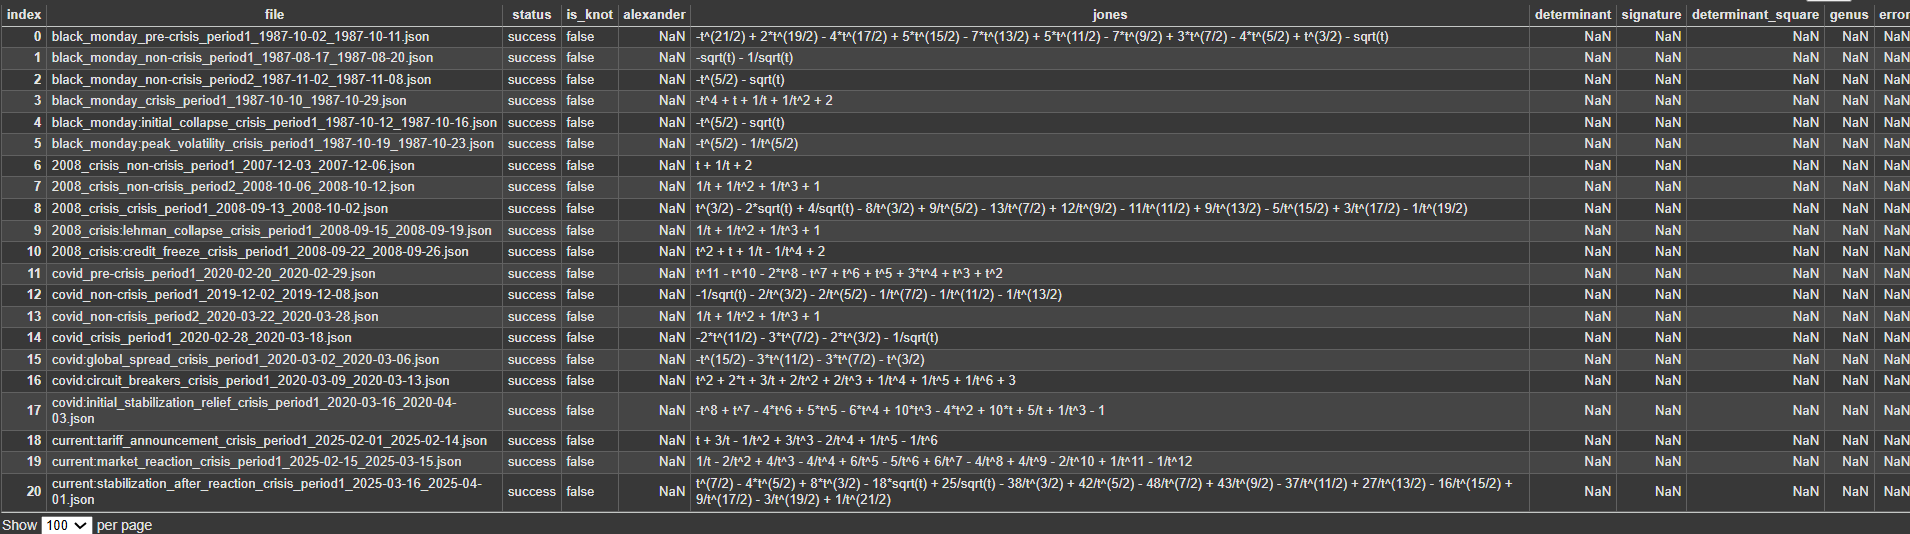